# [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Data from https://www.python-course.eu/neural_network_mnist.php
train_data = np.loadtxt('mnist/train.csv', delimiter=',') 
test_data = np.loadtxt('mnist/test.csv', delimiter=',') 

trn_X = train_data[:, 1:]
trn_y = train_data[:, :1]
tst_X = test_data[:, 1:]
tst_y = test_data[:, :1]

In [3]:
# Values range from 0 to 255
trn_X[0:5,125:135]

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,  51., 159., 253., 159.,  50.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]])

(60000, 784)

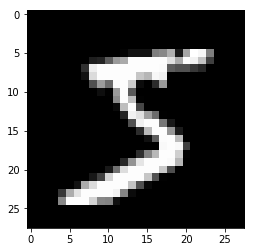

In [4]:
# Show an image
plt.imshow(trn_X[0].reshape(28, 28), cmap='gray')
trn_X.shape

## PyTorch

In [5]:
import torch

# Convert NumPy arrays to torch tensors
trn_X, trn_y, tst_X, tst_y = map(torch.tensor, (trn_X, trn_y, tst_X, tst_y))

trn_X = trn_X.type('torch.FloatTensor')
trn_y = trn_y.type('torch.FloatTensor')
tst_X = tst_X.type('torch.FloatTensor')
tst_y = tst_y.type('torch.FloatTensor')

In [6]:
type(trn_X)

torch.Tensor

### Create a neural network from scratch

In [248]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
# trailing _'s in PyTorch signifies an in-place operation
weights.requires_grad_()
# bias: kind of like a coefficient added to each term
bias = torch.zeros(10, requires_grad=True)
weights

tensor([[ 0.0131,  0.0550,  0.0669,  ...,  0.0438,  0.0040,  0.0511],
        [ 0.0107, -0.0551, -0.0221,  ..., -0.0093,  0.0449, -0.0167],
        [ 0.0151, -0.0089,  0.0233,  ..., -0.0076, -0.0173,  0.0570],
        ...,
        [-0.0170, -0.0657, -0.0002,  ..., -0.0210,  0.0430, -0.0179],
        [-0.0001,  0.0762,  0.0102,  ...,  0.0157,  0.0332,  0.0038],
        [-0.0398, -0.0218,  0.0267,  ...,  0.0211,  0.0179,  0.0235]],
       requires_grad=True)

In [8]:
# Activation function
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

log_softmax(torch.tensor([0.0, 1.0]))

tensor([-1.3133, -0.3133])

In [21]:
# Activation function
def sigmoid(x):
    return 1 / (1 + (-x).exp())

In [9]:
# Example to understand log_softmax
test_tensor = torch.tensor([[1, 2, 3], [4, 5, 6]]).type(torch.FloatTensor)
print(test_tensor.shape)
print(test_tensor.exp())
print(test_tensor.exp().sum(-1))
print(test_tensor.exp().sum(-1).log())
print(test_tensor.exp().sum(-1).unsqueeze(-1))
print(test_tensor - test_tensor.exp().sum(-1).unsqueeze(-1))

torch.Size([2, 3])
tensor([[  2.7183,   7.3891,  20.0855],
        [ 54.5982, 148.4132, 403.4288]])
tensor([ 30.1929, 606.4401])
tensor([3.4076, 6.4076])
tensor([[ 30.1929],
        [606.4401]])
tensor([[ -29.1929,  -28.1929,  -27.1929],
        [-602.4401, -601.4401, -600.4401]])


In [22]:
# Model for learning
def model_old(batch):
    return log_softmax(batch @ weights + bias)
# Note: @ is the dot product operation

def model(batch):
    return sigmoid(batch @ weights + bias)

In [11]:
# Check to make sure dimensions line up
trn_X.shape, weights.shape

(torch.Size([60000, 784]), torch.Size([784, 10]))

In [201]:
batch_size = 64

batch = trn_X[0:batch_size]
predictions = model(batch)
predictions[5:10], predictions.shape

(tensor([[0.0000e+00, 0.0000e+00, 6.3396e-08, 1.0000e+00, 0.0000e+00, 1.0000e+00,
          9.9993e-01, 1.0000e+00, 1.0000e+00, 0.0000e+00],
         [0.0000e+00, 5.0794e-24, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          0.0000e+00, 4.7604e-01, 5.6044e-15, 2.0962e-12],
         [0.0000e+00, 1.0676e-21, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
          0.0000e+00, 1.9617e-05, 9.9449e-01, 9.8425e-01],
         [0.0000e+00, 6.5201e-22, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          6.7457e-11, 9.9995e-01, 1.4409e-09, 1.0103e-24],
         [0.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00, 1.0000e+00,
          0.0000e+00, 9.9047e-01, 1.0000e+00, 0.0000e+00]],
        grad_fn=<SliceBackward>), torch.Size([64, 10]))

In [234]:
# Loss function: the higher, the worse the model performs
def neg_log_likelihood(predictions, target):
    return -predictions[range(target.shape[0]), target.type(torch.LongTensor)].mean()

# gather: gathers values along an axis with a specified tensor as indices
# view: reshapes it to the specified shape in each dimension
def loss_2(predictions, target):
    target_indices = torch.gather(predictions, 1, target.view(-1, 1).type(torch.LongTensor))
    return (target_indices + 0.01).log().mean() / (-1 * predictions.shape[0])
    # return (target @ target_indices.log() + 
    #    ((1 - target) @ (1 - target_indices)).log()).squeeze() / (-1 * predictions.shape[0])
    
def mean_squared(predictions, target):
    target_indices = torch.gather(predictions, 1, target.view(-1, 1).type(torch.LongTensor))
    return ((1 - target_indices) ** 2).sum() / predictions.shape[0]

loss_function = mean_squared

In [239]:
# Example
test_pred = torch.tensor([[0.9, 0.1, 0.5], [0.1, 0.9, 0.5]]).type(torch.FloatTensor)
test_target = torch.tensor([[2, 1]]).type(torch.FloatTensor)

loss_function(test_pred, test_target)

tensor(0.1300)

In [241]:
print(predictions.shape, trn_y[0:batch_size].shape)
loss_function(predictions, trn_y[0:batch_size])

torch.Size([64, 10]) torch.Size([64, 1])


tensor(0.6875, grad_fn=<DivBackward0>)

In [242]:
# Example to understand neg_log_likelihood
test_pred = torch.tensor([[-1, -2, -3], [-4, -5, -6]]).type(torch.FloatTensor)
test_target = torch.tensor([[1], [2]]).type(torch.FloatTensor)
print(test_pred.shape, test_target.shape)
print(range(test_target.shape[0]), test_target)
print(test_pred[range(test_target.shape[0]), test_target.type(torch.LongTensor)])
print(-test_pred[range(test_target.shape[0]), test_target.type(torch.LongTensor)].mean())
# Honestly, I don't understand their code for log_softmax and neg_log_likelihood

torch.Size([2, 3]) torch.Size([2, 1])
range(0, 2) tensor([[1.],
        [2.]])
tensor([[-2., -5.],
        [-3., -6.]])
tensor(4.)


In [243]:
# Accuracy function
def accuracy(predictions, target):
    preds = torch.argmax(predictions, dim=1)
    return (preds == target).float().mean()

In [244]:
accuracy(predictions, trn_y[0:batch_size])

tensor(0.0886)

#### Training the model

In [249]:
def train():
    learning_rate = 0.01
    epochs = 1
    
    for epoch in range(epochs):
        # Run through all the data in batches
        for i in [0]:#range((trn_X.shape[0] - 1) // batch_size + 1):
            start = i * batch_size
            end = start + batch_size
            batch_X = trn_X[start:end]
            batch_y = trn_y[start:end]
            predictions = model(batch_X)
            model_loss = loss_function(predictions, batch_y)
            
            # Calculate gradients on weights and bias
            model_loss.backward()
            # Update weights and bias, but don't calculate gradients for this process
            with torch.no_grad():
                global weights, bias
                weights -= weights.grad * learning_rate
                bias -= bias.grad * learning_rate
                # Set gradients to zero so gradients are correct for next loop
                weights.grad.zero_()
                bias.grad.zero_()

In [250]:
weights, bias

(tensor([[ 0.0131,  0.0550,  0.0669,  ...,  0.0438,  0.0040,  0.0511],
         [ 0.0107, -0.0551, -0.0221,  ..., -0.0093,  0.0449, -0.0167],
         [ 0.0151, -0.0089,  0.0233,  ..., -0.0076, -0.0173,  0.0570],
         ...,
         [-0.0170, -0.0657, -0.0002,  ..., -0.0210,  0.0430, -0.0179],
         [-0.0001,  0.0762,  0.0102,  ...,  0.0157,  0.0332,  0.0038],
         [-0.0398, -0.0218,  0.0267,  ...,  0.0211,  0.0179,  0.0235]],
        requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

In [251]:
train()
weights, bias

(tensor([[    nan,     nan,     nan,  ...,     nan,     nan,  0.0511],
         [    nan,     nan,     nan,  ...,     nan,     nan, -0.0167],
         [    nan,     nan,     nan,  ...,     nan,     nan,  0.0570],
         ...,
         [    nan,     nan,     nan,  ...,     nan,     nan, -0.0179],
         [    nan,     nan,     nan,  ...,     nan,     nan,  0.0038],
         [    nan,     nan,     nan,  ...,     nan,     nan,  0.0235]],
        requires_grad=True),
 tensor([       nan,        nan,        nan,        nan, 0.0000e+00,        nan,
         0.0000e+00,        nan,        nan, 1.5091e-09], requires_grad=True))